# Currency Named Entity Recognition

## Objective:

_Use Named Entity Recognition techniques to identify what currencies (Please refer to Appendix for definition) are mentioned in a news article. We do not require the offset position, only the type of currency or currencies that appear in a document._

In [34]:
# Libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import spacy
from spacy import displacy
import re

In [2]:
# Files and Directory
for root, dirs, files in os.walk(os.path.join('..','Data'), topdown=False):
   for name in files:
      print(os.path.join(root, name))
   for name in dirs:
      print(os.path.join(root, name))

..\Data\test\0002_20171221_nFCT20VZKW_1.txt
..\Data\test\001_kip.txt
..\Data\test\001_yahoo.txt
..\Data\test\002_3_pound.txt
..\Data\test\014_4_FRF.txt
..\Data\test\015_4_FRF.txt
..\Data\test\016_pound_compiled.txt
..\Data\test\023_3_pound.txt
..\Data\test\0243_20170120_nDJMS0289D_1.txt
..\Data\test\0244_20180416_nFCT16ZCHB_1.txt
..\Data\test\0245_20180416_nNRA5ww5ev_1.txt
..\Data\test\0246_20180412_nFCT12YTNH_1.txt
..\Data\test\0252_20180208_nDJR3bC0N3_1.txt
..\Data\test\0254_20180416_nFCT16ZBVC_1.txt
..\Data\test\0256_20180413_nFCT13ZBHB_1.txt
..\Data\test\025_4_RON.txt
..\Data\test\025_real_compiled.txt
..\Data\test\0264_20170522_nNRA3uzj3l_1.txt
..\Data\test\0265_20180406_nFCT06YQHJ_1.txt
..\Data\test\0266_20180416_nDJR8QxpNN_1.txt
..\Data\test\0267_20170725_nL9N1FO00P_1.txt
..\Data\test\026_3_pound.txt
..\Data\test\026_4_RON.txt
..\Data\test\026_real_compiled.txt
..\Data\test\033_compiled.txt
..\Data\test\0351_20180412_nL8N1RP4IS_1.txt
..\Data\test\0352_20170824_nL4N1LA24C_1.txt
.

In [3]:
train_files_size = len(os.listdir(os.path.join('..','Data','train')))
test_files_size = len(os.listdir(os.path.join('..','Data','test')))

print(f'no. of files in train folder: {train_files_size}')
print(f'no. of files in test folder: {test_files_size}')

no. of files in train folder: 346
no. of files in test folder: 145


In [4]:
# Read Lexicon Data
df_lexicon = pd.read_csv(os.path.join('..','Data','lexicon.csv'))

In [5]:
df_lexicon.sample(10)

phrase  ric
124  Indonesian rupiah's  IDR
20      Hungary's forint  HUF
248       Lebanese pound  LBP
180        Russian Ruble  RUB
18      Hungarian forint  HUF
59          Indian rupee  INR
128                franc  CHF
140       China offshore  CNH
139        Swedish Krona  SEK
40          U.S. dollar,  USD

In [6]:
df_lexicon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   phrase  249 non-null    object
 1   ric     249 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB


In [7]:
df_lexicon.describe()

phrase  ric
count            249  249
unique           246   56
top     China's yuan  USD
freq               2   29

There are __249__ rows in the lexicon dataset of which only __56__ are unique. <br>
The most frequently occuring currency is __USD__ which occurs __29__ times.

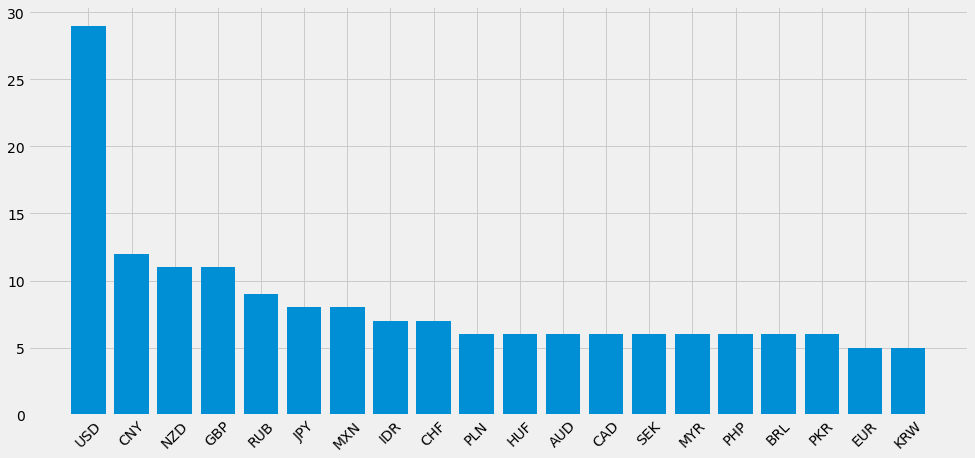

In [8]:
# Top 20 frequently occuring currencies in the lexicon dataset
all_currencies = Counter(df_lexicon.ric)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,7))
plt.xticks(rotation='45')
plt.bar(*zip(*all_currencies.most_common(20)))
plt.show()

In [9]:
df_train = pd.read_csv(os.path.join('..','Data','train_labels.csv'))

In [10]:
df_train.sample(10)

doc_id  phrase  ric
53       EN_ugSX2mIBl1cNDqRBHYbQ     USD  USD
802   0717_20180405_nFCT05YPJJ_1     GBP  GBP
446   0459_20180404_nFCT04YPCT_1     USD  USD
159      EN_twSX2mIBl1cNDqRBK5QZ    yuan  CNY
2839  0646_20180412_nFCT12YTNH_1     SGD  SGD
1668  0722_20180412_nFCT12YZGR_1  Aussie  AUD
3245  0357_20180412_nFCT12YTNC_1     TWD  TWD
3226  0357_20180412_nFCT12YTNC_1     CNH  CNH
2080     EN_fQSX2mIBl1cNDqRBK5QZ     EUR  EUR
3259  0357_20180412_nFCT12YTNC_1  rupiah  IDR

In [11]:
currency_counts = df_train.groupby('doc_id').agg({'doc_id':'count'}).rename(columns = {'doc_id':'count_of_unique_currencies'}).reset_index()

In [12]:
currency_counts.sort_values(by = 'count_of_unique_currencies',ascending=False,inplace=True)

In [13]:
# Documents with the highest currency count
currency_counts.head(10)

doc_id  count_of_unique_currencies
29  0357_20180412_nFCT12YTNC_1                         251
60  0646_20180412_nFCT12YTNH_1                         227
84  0725_20180410_nFCT10YSBS_1                         212
41  0459_20180404_nFCT04YPCT_1                         206
6   0242_20180416_nFCT16YVKR_1                         180
81  0717_20180405_nFCT05YPJJ_1                         138
55  0638_20180411_nFCT11YSTK_1                         108
14  0262_20180102_nFCT02WDZN_1                         108
48  0562_20180102_nFCT02WDZN_1                         108
22  0274_20180412_nFCT12YZGR_1                         100

In [14]:
# Documents with the lowest currency count
currency_counts.tail(10)

doc_id  count_of_unique_currencies
93   0743_20170922_nI8N1K8021_1                           2
106              261_nNRAahokry                           2
115              360_nL5N26133X                           2
100                159_nPth2jlr                           2
119              389_nNRAa8sb6y                           1
107              262_nNRA79wksz                           1
109              290_nNRA9kr0uy                           1
113              305_nL3N2600MH                           1
21   0273_20180409_nASO000334_1                           1
28   0353_20180112_nL4N1P720M_1                           1

_Lets check what are the currencies in the labelled train set for the documents with highest and lowest currency entity count_

In [15]:
df_all_currencies_in_training = df_train.groupby('doc_id')['ric'].agg(lambda x: list(x)).reset_index()

In [16]:
df_all_currencies_in_training[df_all_currencies_in_training.doc_id =='0357_20180412_nFCT12YTNC_1']

doc_id  \
29  0357_20180412_nFCT12YTNC_1   

                                                  ric  
29  [USD, CAD, EUR, USD, USD, JPY, AUD, USD, NZD, ...

In [17]:
df_all_currencies_in_training[df_all_currencies_in_training.doc_id =='0357_20180412_nFCT12YTNC_1']['ric']

29    [USD, CAD, EUR, USD, USD, JPY, AUD, USD, NZD, ...
Name: ric, dtype: object

In [18]:
 highest_counts = Counter(list(df_all_currencies_in_training[df_all_currencies_in_training.doc_id =='0357_20180412_nFCT12YTNC_1']['ric'])[0])

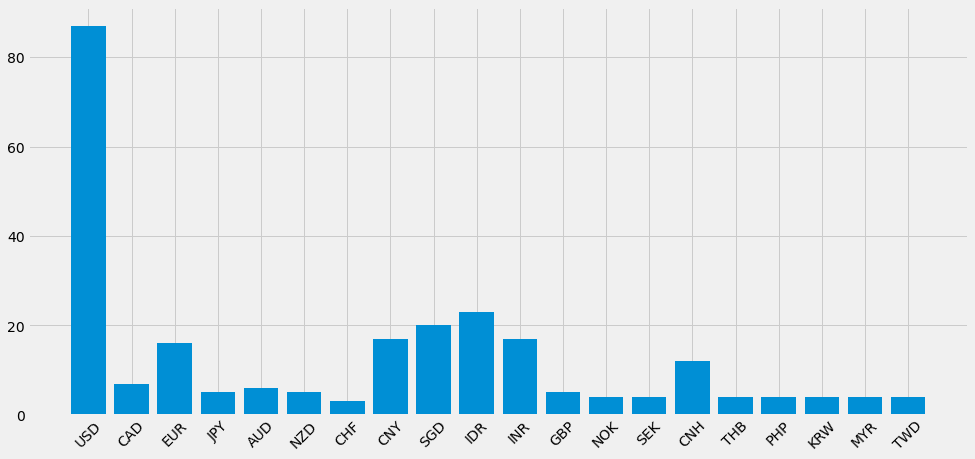

In [19]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,7))
plt.xticks(rotation='45')
plt.bar(*zip(*highest_counts.items()))
plt.show()

In [20]:
highest_counts.items()

dict_items([('USD', 87), ('CAD', 7), ('EUR', 16), ('JPY', 5), ('AUD', 6), ('NZD', 5), ('CHF', 3), ('CNY', 17), ('SGD', 20), ('IDR', 23), ('INR', 17), ('GBP', 5), ('NOK', 4), ('SEK', 4), ('CNH', 12), ('THB', 4), ('PHP', 4), ('KRW', 4), ('MYR', 4), ('TWD', 4)])

In [21]:
len(highest_counts)

20

_The most frequently occuring currency in the doc __0357_20180412_nFCT12YTNC_1__ is USD and has mentions of about 20 different currencies_.

_It is also observed that USD is most occuring entity in the train dataset. We improve the model by getting more data for other currencies as well_

Now, lets use spacy to detect entities in some sample sentences.

In [23]:
def display_entities_in_text(model,text):
    doc = nlp(text)
    displacy.render(doc, style="ent")
    displacy.render(doc,jupyter=True ,style="dep")


In [24]:
# Currency

display_entities_in_text(nlp,'The unilateral repudiation of the multilateral agreement with Iran and the threat by the US to impose sanctions of countries that continue to do business with Iran carries a much broader threat to the Euro and Euro pairs.')

In [25]:
# Currency

display_entities_in_text(nlp,'JPM says add to Cad longs through a USD/CAD (put RKO) pre BOC.')

In [26]:
# Currency

display_entities_in_text(nlp,'The dollar falls against most currencies.')

In [27]:
display_entities_in_text(nlp,'That after the yuan on Thursday posted its largest one-day onshore slide since the 2015 devaluation.')

In [28]:
# Not a Currency

display_entities_in_text(nlp,'Laird said revenue in sterling grew by 26% to 215 million pounds.')

In [29]:
# Not a Currency

display_entities_in_text(nlp,'The Iranian regime and its Central Bank have abused access to entities in the UAE to acquire US dollars to fund the IRGC-QF’s activities.')

_The vanila Spacy model does not detect the currencies as expected._

But by looking at the above POS tags and synactic dependency parsing, the documents where it is expected to tag a currency entity have a few things in common. <br>
> 1. For the example sentences, the desired currency entity are having either a __NOUN or PROPN__ POS tag.
> 2. and almost in all the cases where it should be tagged are having __nsubj__ (_nominal subject_) dependency 


> 1. Create training data using phrasematcher for custom NER using training dataset.
> 2. Take the phrase from training df and use it to get the offsets and make training data.

> 3. Test Tagging.
> 4. Load each document and pass through spacy ,take doc.sents
> 5. Apply textblob sentiment,
> 6. Only for +ve or -ve sentiment, not neutral apply NER.



In [33]:
df_train.tail(10)

doc_id       phrase  ric
4070  0725_20180410_nFCT10YSBS_1          IDR  IDR
4071  0725_20180410_nFCT10YSBS_1          USD  USD
4072  0725_20180410_nFCT10YSBS_1          INR  INR
4073  0725_20180410_nFCT10YSBS_1   U.S dollar  USD
4074  0725_20180410_nFCT10YSBS_1   U.S dollar  USD
4075  0725_20180410_nFCT10YSBS_1   U.S dollar  USD
4076     EN_lASX2mIBl1cNDqRBLJf2  Swiss Franc  CHF
4077     EN_lASX2mIBl1cNDqRBLJf2  Swiss franc  CHF
4078     EN_lASX2mIBl1cNDqRBLJf2         yuan  CNY
4079     EN_lASX2mIBl1cNDqRBLJf2         euro  EUR

In [31]:
def open_file_and_display(filename):
    filename = filename+'.txt'
    with open(os.path.join('..','Data','train',filename)) as reader:
        text = reader.read()
        print(text)
        
        doc = nlp(text)
        sentence_spans = list(doc.sents)
        displacy.render(sentence_spans,jupyter=True ,style="dep")

open_file_and_display('EN_lASX2mIBl1cNDqRBLJf2')



DJ Weak Swiss Franc Helps Boost Watch Industry: Deutsche Bank -- Market Talk
[EURCHF=](reuters://REALTIME/Verb=FullQuote/ric=EURCHF=)

  

1311 GMT - A strong acceleration in the expected production of Swiss watches,
in addition to the weakening Swiss franc against the euro and yuan, could help
bolster growth in the watch industry, according to Deutsche Bank. Analysts say
that the expected production figures released by the KOF Swiss Economic
Institute for the next three months are impressive, and highlight a " tangible
improvement" in industry confidence.
([euan.conley@dowjones.com](mailto:euan.conley@dowjones.com))

  

(END) Dow Jones Newswires




In [32]:
open_file_and_display('0725_20180410_nFCT10YSBS_1')

ev: 1.8]

EVENTS & AUCTIONS

  

  * EU: ECB's Nowotny Speaks in London
  * 07:30 GMT - EU: ECB's Nouy Speaks in Ljubljana, Slovenia
  * 08:00 GMT - JP: Enhanced-Liquidity Auction
  * 09:30 GMT - UK: 2057 Bond 1.75% Auction (GBP 2bn)
  * 09:30 GMT - UK: BoE's Haldane Speaks in Melbourne
  * 15:30 GMT - US: 4wk Bills Auction
  * 15:30 GMT - EU: ECB's Visco Speaks in Rome, Italy
  * 17:00 GMT - US: 3yr Notes Auction
  * 22:30 GMT - US: Fed's Bostic Speaks in Cambridge, Mass.

09 Apr 2018 08:40 GMT - Asia Close Highlights

  

09 April 2018

  

Regional Backdrop:

  

Asian currencies were mixed on Monday. KRW (+0.24%), MYR (0.14%), IDR (0.08%)
and SGD (0.07%) all registered some gains, while TWD (-0.23%), THB (-0.22%),
CNY (-0.2%), CNH (-0.15%), INR (-0.03%) lost against the USD. Philippines
markets were closed today for a local holiday. Markets remained watchful for
US-China trade relations and any possibility for further moves or
negotiations. This comes as Asian stocks rebounded.

  

On looking at multiple documents, below are the observations:
> 1. The training data corpus contains scrapings from Financial News Articles. 
> 2. Some amount of cleaning is required.
    >> 1. Striping of extra spaces.
    >> 2. Removing Numerical Characters, for this task it does not add any value to the training.
    >> 3. Removal of URL's : As mentioned in the appendix, we need not detect entities in URL's.
